In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from scipy.io import savemat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)


with open('YALE_Shortness_of_Breath.npy', 'rb') as f:
    X_train = np.load(f)
    y_train = np.load(f).reshape(-1)
    X_test = np.load(f)
    y_test = np.load(f).reshape(-1)

classes = ['0', '1']

n = X_train.shape[0]
    
print(X_train.shape, y_train.shape, X_train.dtype)
print(X_test.shape, y_test.shape, X_test.dtype)
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(19721, 1003) (19721,) float64
(4931, 1003) (4931,) float64


/home/ponir/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


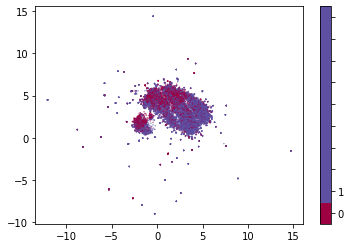

In [2]:
import umap


np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

y_umap = ump.fit_transform(X_train)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.1, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

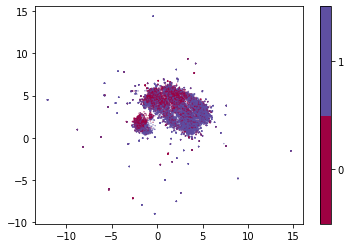

In [3]:
plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.1, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(len(classes)+1)-0.5)
cbar.set_ticks(np.arange(len(classes)))
cbar.set_ticklabels(classes)

In [4]:
dist = euclidean_distances(X_train, squared = False)

#with open('mnist_distances.npy', 'rb') as f:
#    dist = np.load(f)


#print(dist[0:4, 0:4])
print('\n')

    


In [5]:
print(dist[0:4, 0:4])
print( np.sum((X_train[1,:] - (X_train[6,:]+X_train[5,:]))**2))

[[0.         6.19284193 6.42256474 6.24340715]
 [6.19284193 0.         5.96575614 5.35960148]
 [6.42256474 5.96575614 0.         6.15812382]
 [6.24340715 5.35960148 6.15812382 0.        ]]
77.46985801144501


In [6]:
n_neighbors=30

sort_idx = np.argsort(dist,axis=1)

sort_idx = sort_idx[:,1:n_neighbors+1]
print(sort_idx.shape, sort_idx[:,1].shape)

rho = [ dist[i, sort_idx[i,0] ] for i in range(n)]
rho = np.array(rho)

print(rho[0:4])
print(rho.shape, rho.dtype)

(19721, 30) (19721,)
[4.12518884 2.46179381 4.0812828  3.73355506]
(19721,) float64


In [7]:
#print(dist[0,[0,1,5,6]])
#print(dist[0,0:7])

import gc

print(gc.collect())

#with open('rho_mnist.npy', 'wb') as f:
#    np.save(f, rho)
    
#print(rho.shape)

33222


In [8]:
'''
def prob_high_dim(sigma, dist_row):
    """
    For each row of Euclidean distance matrix (dist_row) compute
    probability in high dimension (1D array)
    """
    d = dist[dist_row] - rho[dist_row];
    d[ d < 0 ] = 0
    return np.exp(-d / sigma)

def k(prob):
    """
    Computer n_neighbor = k (scalar) for each 1D array of high-dimensional probability
    """
    return np.power(2, np.sum(prob))
'''
temp = 0

In [9]:
def get_weight_function(dists, rho, sigma):
    d = dists - rho
    #print(d)
    d[d<0] = 0
    weight = np.exp(- d / sigma )
    return weight


def search_sigma(dists, rho, k, tol = 10**-5, n_iteration=200):
    sigma_min = 0
    sigma_max = 1000
    
    cur_sigma = 100
    
    logk = np.log2(k)
    #print(logk)
    
    for i in range(n_iteration):
        
        cur_sigma = (sigma_min+sigma_max)/2
        probs = get_weight_function(dists,rho,cur_sigma)
        weight = np.sum(probs)
        #print(weight)
        
        if np.abs(logk - weight) < tol:
            break
        
        if weight < logk:
            sigma_min = cur_sigma
        else:
            sigma_max = cur_sigma
        
    return cur_sigma, probs

#sigma, weights = search_sigma(dists = dist[0,sort_idx[0,:]],rho = rho[0],k = n_neighbors)

#print(np.sum(np.exp( -(dist[0,1:] - rho[0]) / sigma ) ))

#print(dist[0,:] - rho[0], dist[0,0], rho[0])

#print(sigma)

In [10]:
sigmas = []

directed_graph = []
#'''
for i in range(n):
    if (i+1)%1000 == 0:
        print('Processed ', i+1, ' of ', n, ' samples.')
    sigma, weights = search_sigma(dists = dist[i,sort_idx[i,:]],rho = rho[i],k = n_neighbors)
    
    probs = np.zeros(n)
    probs[sort_idx[i,:]] = weights
    #print(sum(weights), np.log2(n_neighbors))
    #print(sort_idx[i,:])
    #print(probs[1770:1780])
    
    directed_graph.append(probs)

prob = np.array(directed_graph)
#'''  

#with open('probs_n_neighbor30.npy', 'rb') as f:
#    prob = np.load(f)
    

dist = []
print(gc.collect())
    
#print(prob.shape)


#print(prob[0:10,0:10])

Processed  1000  of  19721  samples.
Processed  2000  of  19721  samples.
Processed  3000  of  19721  samples.
Processed  4000  of  19721  samples.
Processed  5000  of  19721  samples.
Processed  6000  of  19721  samples.
Processed  7000  of  19721  samples.
Processed  8000  of  19721  samples.
Processed  9000  of  19721  samples.
Processed  10000  of  19721  samples.
Processed  11000  of  19721  samples.
Processed  12000  of  19721  samples.
Processed  13000  of  19721  samples.
Processed  14000  of  19721  samples.
Processed  15000  of  19721  samples.
Processed  16000  of  19721  samples.
Processed  17000  of  19721  samples.
Processed  18000  of  19721  samples.
Processed  19000  of  19721  samples.
0


In [11]:
import gc
gc.collect()

#P = prob + np.transpose(prob) - np.multiply(prob, np.transpose(prob))
#P = (prob + np.transpose(prob)) / 2
 

#'''
import numba 
from numba import prange
@numba.jit(nopython=True, parallel=True)
def symmetrization_step(prob):
    P = np.zeros((n,n),dtype=np.float32)

    for i in prange(n):
        #if i%1000 == 0:
        #    print('Completed ', i, ' of ', n)
        for j in prange(i,n):
            p = prob[i,j] + prob[j,i] - prob[i,j] * prob[j,i]
            P[i,j] = p
            P[j,i] = p
            
    return P


P = symmetrization_step(prob)
#'''
print(np.sum(P[0,:]==0))

    

print(P.shape)

19686
(19721, 19721)


In [12]:
print(P[0,P[0,:]>0])
np.sum(P[0,P[0,:]>0])

[0.14872491 0.09216202 0.14216167 0.18695085 0.1454319  0.21050702
 0.10956557 0.08885105 0.1260764  0.08225131 0.1013618  0.11659338
 0.1596699  0.10568023 0.14463674 0.11507425 0.1336074  0.18297608
 0.0836058  0.12399733 0.12533206 0.09186868 0.0835101  0.23454612
 0.09552567 0.09855004 0.08291634 0.21313095 0.18816568 0.3124558
 0.09163693 1.         0.17733027 0.09014603 0.07799812]


5.562999

Hyperparameters a = 1.576943460405378 and b = 0.8950608781227859


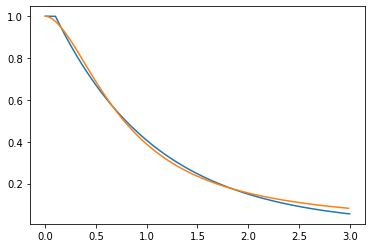

In [13]:
MIN_DIST = 0.1

x = np.linspace(0, 3, 300)
y = np.exp(- (x-MIN_DIST) * ( (x - MIN_DIST) >=0 ) )

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(dist_low_dim, x, y)

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

x_p = np.arange(0,3,0.01)
y_p = np.exp(- (x_p-MIN_DIST) * ( (x_p - MIN_DIST) >=0 ) )
y_p2 = 1 / (1 + a*x_p**(2*b))

plt.figure()
plt.plot(x,y, label='Target')
plt.plot(x_p,y_p2, label='Fitted')

In [14]:
import torch
from network_sig import network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = network(channels=[X_train.shape[1],500,300,200,100,100,100,2]).to(device)


criterion_mse = torch.nn.MSELoss()

lr = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))


In [15]:
Y = []
X_train32 = X_train.astype(np.float32)

print('Conversion Done')
X_torch = torch.as_tensor(X_train32, dtype=torch.float32).to(device)
Y_umap = torch.as_tensor(y_umap, dtype=torch.float32).to(device)

X_torch_test = torch.as_tensor(X_test, dtype=torch.float32).to(device)
print('Tensor Build Done')


Conversion Done
Tensor Build Done


completed  0  of  19721
completed  10000  of  19721
(19721, 2)


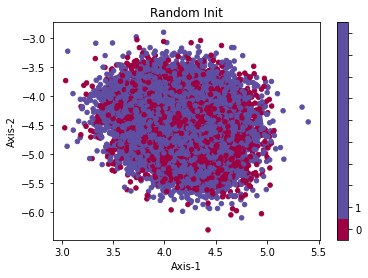

In [16]:
Y = []

with torch.no_grad():
    for i in range(n):
        if i%10000 == 0:
            print('completed ', i, ' of ', n)
            
        x_st = X_torch[i:i+1,:]
        #print(x_st.size())
        y_st = model(x_st).cpu().numpy().reshape(-1)
        #print(y_st.shape)
        Y.append(y_st)

Y = np.array(Y)
print(Y.shape)


plt.figure()#figsize=(20,15))
plt.scatter(Y[:,0], Y[:,1], c = y_train.astype(int), cmap = 'Spectral', s = 20)
plt.title("Random Init")
plt.xlabel("Axis-1") #, fontsize = 20); 
plt.ylabel("Axis-2") #, fontsize = 20)
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()
plt.show()

In [17]:
def criterion_pos_old(x,y,a,b):
    factor = 1 + a * torch.sum((x-y)**2, dim = 0) ** b
    y = torch.log(factor)
    
    return y

def criterion_neg_old(x,y,a,b):
    factor = a * torch.sum((x-y)**2) ** b
    y = - torch.log(0.0001+factor) + torch.log(1 + factor)
    
    return y

def phi(x,y,a,b):
    factor = 1 + a * torch.sum((x-y)**2+10**-15, dim=1) ** b
    y = 1/factor
    
    return y

def criterion_pos(x,y,a,b):
    prob = phi(x,y,a,b)
    y = -torch.log(prob)
    
    return torch.sum(y)

def criterion_neg(x,y,p,a,b):
    prob = phi(x,y,a,b)
    y = -torch.log(1-prob+0.000001)*(1-p)
    
    return torch.sum(y)
    

Y = model(X_torch[0:10,:])
Z = criterion_pos(Y[0:4,:],Y[4:8,:],1.0,1.0)
print(Y.size(), Z.size(), Z.item())

torch.Size([10, 2]) torch.Size([]) 0.8272881507873535


In [18]:
#from sklearn.manifold import SpectralEmbedding


#LEARNING_RATE = 1
epochs = 20

#xpp = xpp
#print(k)

batch_size = 60

CE_array = []
results = []
print("Running Gradient Descent: \n")
for epoch in range(epochs):
    
    for idx in range(int(n)):
        choices_0 = np.random.choice(n, batch_size)
        k_ch = np.random.randint(low = 0, high = n_neighbors, size=batch_size)
        choices_1 = sort_idx[choices_0,k_ch]
        
        #print(choices_0.shape,choices_1.shape)
        
        optimizer.zero_grad()
        
        loss = 0
        
        Y0 = model(X_torch[choices_0,:])
        Y1 = model(X_torch[choices_1,:])
        
        cr = criterion_pos(Y0, Y1, a, b) + criterion_mse(Y0,Y_umap[choices_0,:]) + criterion_mse(Y1, Y_umap[choices_1,:])
        loss = loss + cr
        #print(cr)
        if np.isnan(cr.detach().cpu().item()):
            print(epoch,idx,cr)
            break
        
        #gr_1 = get_grad_logphi(y[i,:], y[ij,:],a,b)
        #y[i,:] = y[i,:] + LEARNING_RATE * gr_1
        
        for j in range(5):
            k_ch = np.random.randint(low = 0, high = n, size=batch_size)
            #Y0 = model(X_torch[i:i+1,:])
            Y1 = model(X_torch[k_ch,:])
            Prob_sample = torch.as_tensor(P[choices_0,k_ch].reshape(-1), dtype=torch.float32).to(device)
            
            cr = criterion_neg(Y0, Y1, Prob_sample, a, b) + criterion_mse(Y1, Y_umap[k_ch,:])
            loss = loss + cr
            #print('inside loop: ', cr)
            if np.isnan(cr.detach().cpu().item()):
                print('inside loop: ', epoch, idx, j, cr)
                break
            
            
        loss.backward()
        optimizer.step()
        
                
    #LEARNING_RATE = 1.0 - epoch / epochs
    if (epoch+1)%1 == 0:
        print('Completed ', epoch , ' of ', epochs)
        torch.save(model.state_dict(), 'nets_MSE_CE_UMAP/epoch'+str(epoch)+'.pth')
        
        Y = []
        Y_test = []
        with torch.no_grad():
            for i in range(n):
                x_st = X_torch[i:i+1,:]
                y_st = model(x_st).cpu().numpy().reshape(-1)
                #print(y_st.shape)
                Y.append(y_st)
            

            
            for i in range(X_test.shape[0]):
                x_st = X_torch_test[i:i+1,:]
                #print(x_st.size())
                y_st = model(x_st).cpu().numpy().reshape(-1)
                #print(y_st.shape)
                Y_test.append(y_st)
        
        Y_test = np.array(Y_test)
        Y = np.array(Y)
        
        neigh.fit(Y, y_train) 
        y_nene_out = neigh.predict(Y_test)
        
        result = 1-np.mean(y_nene_out==y_test)
        
        results.append(result)
        
        d = {}
        d['Y'] = Y
        d['Y_test'] = Y_test
        savemat('nets_MSE_CE_UMAP/test_data'+str(epoch)+'.mat', d)
        
        print('Error :', result)
        
    if (epoch+1)/5 == 0:
        lr = lr/10
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


Running Gradient Descent: 

Completed  0  of  20
Error : 0.3666599067126344
Completed  1  of  20
Error : 0.35753396876901233
Completed  2  of  20
Error : 0.3601703508416143
Completed  3  of  20
Error : 0.3538835935915636
Completed  4  of  20
Error : 0.3506388156560536
Completed  5  of  20
Error : 0.3599675522206449
Completed  6  of  20
Error : 0.3407016832285541
Completed  7  of  20
Error : 0.3400932873656459
Completed  8  of  20
Error : 0.35915635773676735
Completed  9  of  20
Error : 0.34982762117217603
Completed  10  of  20
Error : 0.35753396876901233
Completed  11  of  20
Error : 0.35347799634962485
Completed  12  of  20
Error : 0.3642263232610018
Completed  13  of  20
Error : 0.3563171770431961
Completed  14  of  20
Error : 0.3500304197931454
Completed  15  of  20
Error : 0.34191847495437033
Completed  16  of  20
Error : 0.35510038531737986
Completed  17  of  20
Error : 0.35550598255931865
Completed  18  of  20
Error : 0.3567227742851349
Completed  19  of  20
Error : 0.34901642668

completed  0  of  19721
completed  10000  of  19721
[[ 1.5917721   1.6272005 ]
 [-2.0842035   1.6470562 ]
 [ 5.974159    2.0472481 ]
 ...
 [ 0.7562671   4.3712983 ]
 [ 2.4418592   1.1048933 ]
 [ 0.17252895  6.4232097 ]]


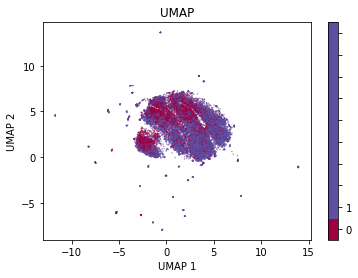

In [19]:
Y = []

with torch.no_grad():
    for i in range(n):
        if i%10000 == 0:
            print('completed ', i, ' of ', n)
            
        x_st = X_torch[i:i+1,:]
        #print(x_st.size())
        y_st = model(x_st).cpu().numpy().reshape(-1)
        #print(y_st.shape)
        Y.append(y_st)

Y = np.array(Y)
print(Y)

plt.figure()#figsize=(20,15))
plt.scatter(Y[:,0], Y[:,1], c = y_train.astype(int), cmap = 'Spectral', s = 0.1)
plt.title("UMAP")
plt.xlabel("UMAP 1") #, fontsize = 20); 
plt.ylabel("UMAP 2") #, fontsize = 20)
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()
plt.show()